In [1]:
import requests
import cv2
from matplotlib import pyplot as plt 
import numpy as  np


# Q1: Edge Detection
Apply an edge detection algorithm to detect the road edges in the image road.jpg. Fine-tune the thresholds to exclusively detect the road edges while minimizing detection of other features in the image. Insert the resultant edge image on the right. Use gray colormap to display.

(Text(0.5, 1.0, 'Canny Edges'), (-0.5, 639.5, 426.5, -0.5))

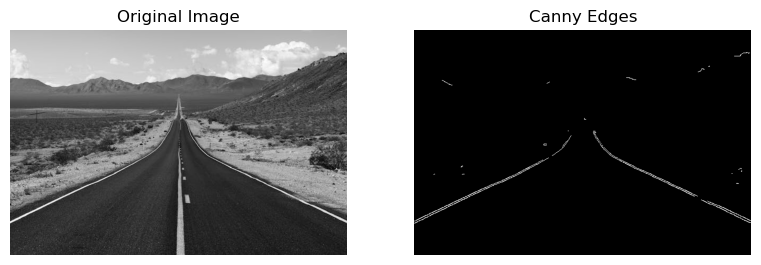

In [22]:
image = cv2.imread('road.jpg')

# Apply the Canny edge detector
edges = cv2.Canny(image, 550, 760)       # 150 and 250 are the thresholds for detecting the edge
                                         # if the edge > 250 --> strong edge
                                         # if 150 < edge < 250 --> weak edge
                                         # if edge < 150 --> not an edge
                                         # strong edges are edges and weak edges are edges iff they're connected to strong ones

# Display the original image and the edges side by side
plt.figure(figsize=(20, 10))
plt.subplot(141), plt.imshow(image, cmap='gray')
plt.title('Original Image'), plt.axis('off')
plt.subplot(142), plt.imshow(edges, cmap='gray')
plt.title('Canny Edges'), plt.axis('off')

# Q2: Filter Design 
Design a 3x3 linear filter that shifts an image 1 pixel downwards and reduces the image brightness by 50%.

The filter would be 

| 0 | 0.5 | 0
| :----------------------------------------------------------- | ---- | ---- |
| 0 | 0| 0
| 0 | 0| 0

(Text(0.5, 1.0, 'Adjusted Image'), (-0.5, 639.5, 426.5, -0.5))

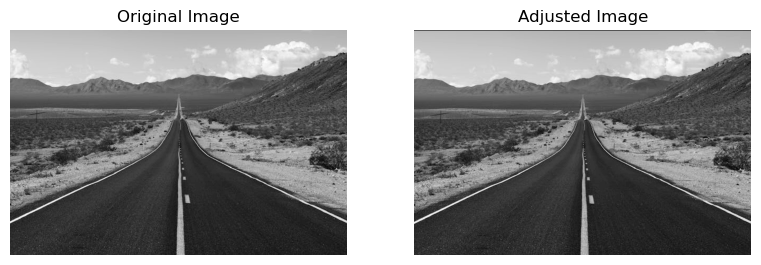

In [25]:
image = cv2.imread('road.jpg', cv2.IMREAD_GRAYSCALE)        # read the image (here we're creating our own filter but OpenCV has its own -- see below)

f = np.array([[0,0.5,0],
                     [0,0,0],
                     [0,0,0]])     

output = cv2.filter2D(src=image, ddepth=cv2.CV_32F, kernel=f, borderType=cv2.BORDER_CONSTANT)
plt.figure(figsize=(20, 10))
plt.subplot(141), plt.imshow(image, cmap='gray')
plt.title('Original Image'), plt.axis('off')
plt.subplot(142), plt.imshow(output, cmap='gray')
plt.title('Adjusted Image'), plt.axis('off')

# Q3: Parameter Count
Find the total number of parameters/weights in the following network. All convolutional filters have size 3x3, stride 1, and pad 1, and all max pool layer size is 2x2, stride 2. All neurons have bias term.
-	Input layer: 32 x 32 x 3
-	Convolutional layer with 16 filters
-	Pool Layer
-	Convolutional layer with 32 filters
-	Fully Connected Layer with 10 neurons

-	Input layer: 32 x 32 x 3
-	Convolutional layer with 16 filters
    - output shape = 32 x 32 x 16
    - weights = 16(3(3*3) + 1) = 448
-	Pool Layer
    - output shape = 16 x 16 x 16
    - weights = 0
-	Convolutional layer with 32 filters
    - output shape = 16 x 16 x 32
    - weights = 32(16(3*3)+1) = 4640
-	Fully Connected Layer with 10 neurons
    - weights - 16*16*32*10 + 10 = 81930

total = 87018 parameters

# Q4: Stitching
Stitch the two images (character1.jpg, character2.jpg) together. Use SIFT to detect and match the keypoints. Improve the matched keypoints using RANSAC.
-	Show the matched keypoints
-	Show the stitched image


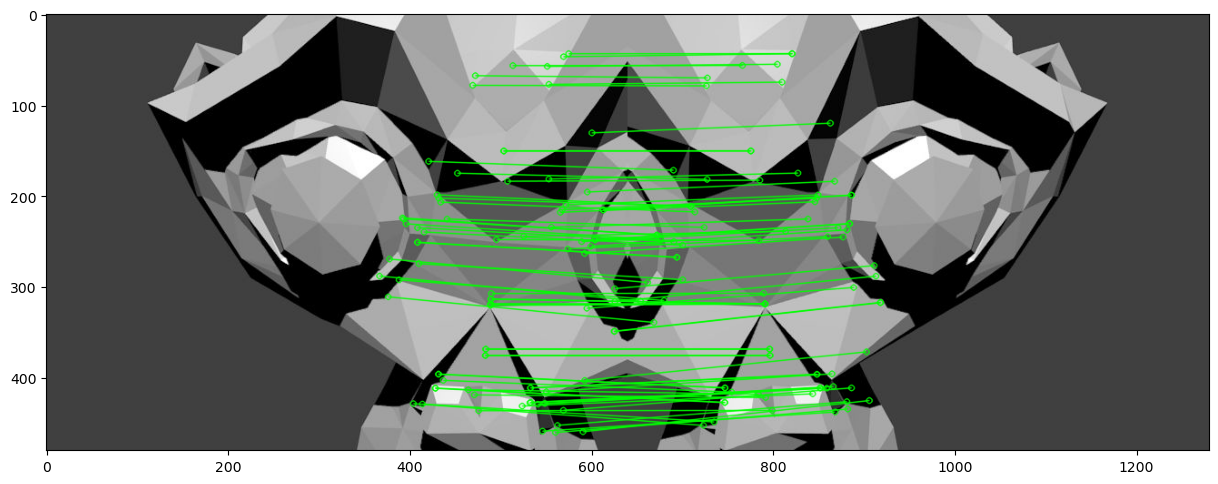

In [27]:
# Load the images
image1 = cv2.imread('character1.jpg')
image2 = cv2.imread('character2.jpg')

# Initialize the ORB detector
feat = cv2.SIFT_create()

# Find the keypoints and descriptors with ORB
kp1, des1 = feat.detectAndCompute(image1, None)
kp2, des2 = feat.detectAndCompute(image2, None)

# Create BFMatcher (Brute Force Matcher)
bf = cv2.BFMatcher()
matches = bf.knnMatch(des1,des2, k=2)

# Apply ratio test
good = []
for m,n in matches:
    if m.distance < 0.75*n.distance:
        good.append(m)

# Extract the matched keypoints
src_pts = np.float32([ kp1[m.queryIdx].pt for m in good ]).reshape(-1,1,2)
dst_pts = np.float32([ kp2[m.trainIdx].pt for m in good ]).reshape(-1,1,2)

# Use RANSAC to estimate the homography matrix
H, mask = cv2.findHomography(src_pts, dst_pts, cv2.RANSAC, ransacReprojThreshold=5)

# Draw the matching 
draw_params = dict(matchColor = (0,255,0), # draw matches in green color
                   singlePointColor = None,
                   matchesMask = mask.ravel().tolist(), # draw only inliers
                   flags = 2)
plt.figure(figsize=(15,15))
output_image = cv2.drawMatches(image1,kp1,image2,kp2,good,None,**draw_params)
plt.imshow(cv2.cvtColor(output_image, cv2.COLOR_BGR2RGB)), plt.show();

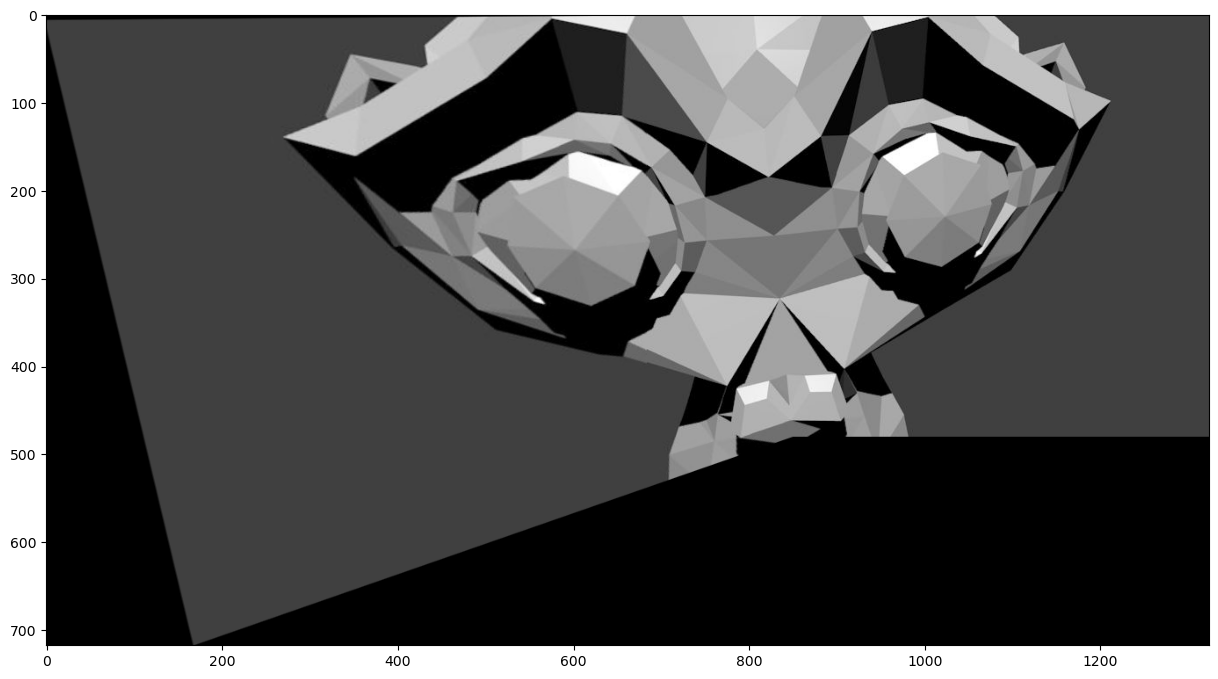

In [28]:
# Find the corners of the transformed image
h1, w1 = image1.shape[:2]
h2, w2 = image2.shape[:2]
corners1 = np.array([[0, 0], [0, h1 - 1], [w1 - 1, h1 - 1], [w1 - 1, 0]], dtype=np.float32).reshape(-1, 1, 2)  # each corner is represented as [[x, y]]     
corners2 = np.array([[0, 0], [0, h2 - 1], [w2 - 1, h2- 1], [w2 - 1, 0]], dtype=np.float32).reshape(-1, 1, 2)

transformed_corners = cv2.perspectiveTransform(corners1, H)                     # only corners 1 undergo transformation
transformed_corners = np.concatenate((transformed_corners, corners2), axis=0)   # concatenate arrs along the rows

# Find the minimum and maximum (transformed) coordinates to get the dimensions of the panoramic image
min_x, min_y = np.int32(transformed_corners.min(axis=0).ravel())                # finding the min & max along the first axis -- (x, y) coordinates
                                                                                # ravel() -- flattens the array results
max_x, max_y = np.int32(transformed_corners.max(axis=0).ravel())

# Adjust the homography matrix to account for the shift
translation_matrix = np.array([[1, 0, -min_x], [0, 1, -min_y], [0, 0, 1]])      # shifting the image by -minx_x & min_y (so that it starts from (0, 0))
adjusted_homography_matrix = np.dot(translation_matrix, H)                      # apply translation to the original homography matrix H

# Apply the adjusted homography to warp the image
stitched_image = cv2.warpPerspective(image1, adjusted_homography_matrix, (max_x - min_x + 1, max_y - min_y + 1))
stitched_image[-min_y:image2.shape[0] - min_y, -min_x:image2.shape[1] - min_x,:] = image2    # overlays image2 onto the stitched image, ensuring that it aligns properly with image1
                                                                                             # the negative indexing is used to ensure correct placement of image2 in the stitched image.

# Display or save the stitched image
plt.figure(figsize=(15,15))
plt.imshow(cv2.cvtColor(stitched_image, cv2.COLOR_BGR2RGB))

# Q5: Neural Network
Design the following CNN in PyTorch.
-	Input Layer: 4 x 4 x 1
-	Convolutional Layer: 2 filters of size 3 x 3 x 1, applied with zero-padding of P = 1, and Stride S = 1.
-	Rectified Linear Unit
-	Max Pooling Layer: Size = 2 x 2, zero-padding P = 0, and stride S = 2.
-	Fully Connected Layer: Two neurons in the fully connected layer.
Apply the neural network above to the following image.

| 2 | 1 | 0 | 5 |
| :----------------------------------------------------------- | ---- | ---- | ---- |
| 4 | 3| 2 | 4|
|1|3|1|2|
|4|2|1|1|



In [29]:
import torch
from torch import nn
from torch import optim
from torch.utils.data import Dataset
from torch.utils.data import DataLoader
from torchvision import datasets
from torchvision import transforms
from torchvision.transforms import ToTensor

import numpy as np
from matplotlib import pyplot as plt

In [51]:
x = torch.tensor([[2,1,0,5], [4,3,2,4], [1,3,1,2],[4,2,1,1]], dtype=torch.float)

class MyModel(nn.Module):
    def __init__(self):
        super().__init__()
        
        self.network = nn.Sequential(
            nn.Conv2d(in_channels=1, out_channels=2, kernel_size=3, padding=1, stride=1),    #output = 4 x 4 x 2
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2),                  #output = 2 x 2 x 2
            nn.Flatten(),
            nn.Linear(2*2*2, 2)
        )
    
    def forward(self, x):        
        return self.network(x)
    
model = MyModel()

new_x = x.reshape((1, 1, 4, 4))
#idkx = x.unsqueeze(0).unsqueeze(0)
out = model(new_x)
out

tensor([[1.3371, 1.1106]], grad_fn=<AddmmBackward0>)